In [8]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
K = tf.keras.backend
import matplotlib.pyplot as plt

In [3]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [5]:
# Reshape 
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

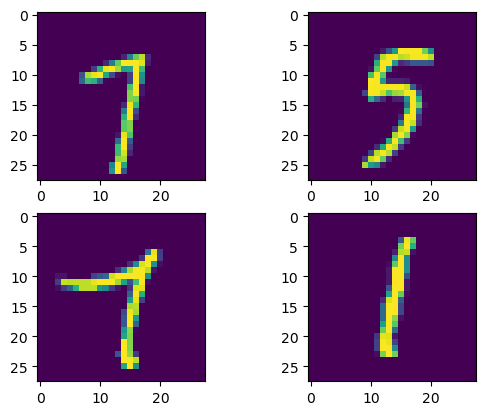

In [6]:
# View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()


In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mu))
        return z_mu + tf.exp(0.5 * z_log_var) * epsilon

In [19]:
latent_dim = 8

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Flatten()(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)

z_mu = layers.Dense(latent_dim, name="z_mu")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mu, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")


In [20]:
decoder_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mu, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                tf.reshape(inputs, [tf.shape(inputs)[0], -1]),
                tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])
            )
        )

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var)
        )

        total_loss = recon_loss + kl_loss

        # 🔴 THIS LINE FIXES YOUR ERROR
        self.add_loss(total_loss)

        return reconstruction

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3070 - val_loss: 0.2656
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2653 - val_loss: 0.2645
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2645 - val_loss: 0.2638
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2639 - val_loss: 0.2635
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2636 - val_loss: 0.2631
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2633 - val_loss: 0.2629
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2632 - val_loss: 0.2628
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2631 - val_loss: 0.2629
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2631 - val_loss: 0.2628
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2631 - val_loss: 0.2627


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


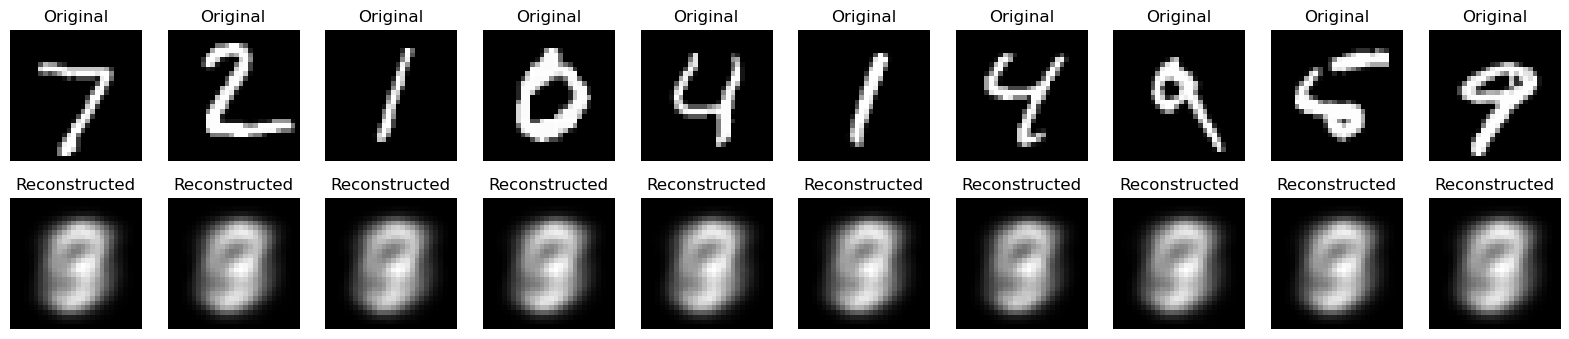

In [23]:
import matplotlib.pyplot as plt

# Take some test images
n = 10
test_imgs = x_test[:n]

# Encode and decode
z_mu, z_log_var, z = encoder.predict(test_imgs)
reconstructed = decoder.predict(z)

# Plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()
